In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Mersenne Twister com NumPy
# Define a semente para reprodutibilidade
np.random.seed(42)  
# ----------------------------- System Parameters -------------------------
# Número de usuários móveis (MSs) no sistema MIMO massivo.
Num_users = 4
# Número de Antenas na Estação Base (TX)
# A estação base (BS) usa uma matriz de antenas plana uniforme (UPA) com 64 antenas.
TX_ant = 64
# TX_ant_w e TX_ant_h calculam a largura e altura da matriz assumindo um arranjo quadrado
TX_ant_w = int(np.sqrt(TX_ant))  # Largura
TX_ant_h = int(np.sqrt(TX_ant))  # Altura

# Cria índices das antenas na matriz UPA para ajudar no mapeamento espacial.
# Índices das antenas no grid da UPA
ind_TX_w = np.repeat(np.arange(TX_ant_w), TX_ant_h)
ind_TX_h = np.tile(np.arange(TX_ant_h), TX_ant_w)

# Número de Antenas no Receptor (RX)
# Cada usuário (MS) tem uma UPA menor de 4 antenas.
RX_ant = 4
# RX_ant_w e RX_ant_h calculam a largura e altura da matriz assumindo um arranjo quadrado
RX_ant_w = int(np.sqrt(RX_ant)) # Largura
RX_ant_h = int(np.sqrt(RX_ant)) # Altura

# Define os índices das antenas da matriz UPA do receptor, de forma similar ao transmissor.
ind_RX_w = np.repeat(np.arange(RX_ant_w), RX_ant_h)
ind_RX_h = np.tile(np.arange(RX_ant_h), RX_ant_w)

# Parâmetros do Canal
Num_paths = 10  # Número de caminhos no canal

# ----------------------------- Parâmetros da Simulação ---------------------
# Cria uma faixa de valores de SNR (Signal-to-Noise Ratio) em decibéis (dB).
SNR_dB_range = np.arange(-10, 25, 5)  # Gera valores de SNR de -10 dB a 20 dB, com incremento de 5 dB

# ----------------------------- Matrizes para Armazenar as Taxas de Transmissão ---------------------
# Taxa para um único usuário (Single User - SU)
Rate_SU = np.zeros(len(SNR_dB_range)) 
# Taxa na estação base (Base Station - BS)
Rate_BS = np.zeros(len(SNR_dB_range)) 
# Taxa usando precoding híbrido (Hybrid Precoding - HP)
Rate_HP = np.zeros(len(SNR_dB_range))  
# Taxa usando Precoding híbrido baseado no critério de erro médio quadrático (MSE)
Rate_HP_MSE = np.zeros(len(SNR_dB_range)) 
# Taxa usando Precoding híbrido usando Filtro de Kalman
Rate_HP_Kalman = np.zeros(len(SNR_dB_range))
# Taxa usando Precoding Totalmente Digital com Zero Forcing (ZF)
Rate_HP_FD_ZF = np.zeros(len(SNR_dB_range))
# Taxa usando 	Precoding Totalmente Digital com MSE
Rate_HP_FD_MSE = np.zeros(len(SNR_dB_range))

# ----------------------------- Número de Iterações ---------------------
# Define 500 iterações para cada valor de SNR, 
# Permite obter médias estatísticas confiáveis, reduzindo a variabilidade dos resultados.
ITER = 500

In [5]:
def generate_massive_mimo_channel(Num_users, Num_paths, RX_ant_w, RX_ant_h, TX_ant_w, TX_ant_h):
    # Inicialização das Matrizes
    H = np.zeros((Num_users, RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)
    a_TX = np.zeros((TX_ant_w * TX_ant_h, Num_users), dtype=complex)
    a_RX = np.zeros((RX_ant_w * RX_ant_h, Num_users), dtype=complex)

    ind_TX_w = np.repeat(np.arange(TX_ant_w), TX_ant_h)
    ind_TX_h = np.tile(np.arange(TX_ant_h), TX_ant_w)
    ind_RX_w = np.repeat(np.arange(RX_ant_w), RX_ant_h)
    ind_RX_h = np.tile(np.arange(RX_ant_h), RX_ant_w)

    AoD_el = np.zeros((Num_users, Num_paths))
    AoD_az = np.zeros((Num_users, Num_paths))
    AoA_el = np.zeros((Num_users, Num_paths))
    AoA_az = np.zeros((Num_users, Num_paths))
    alpha = np.zeros((Num_users, Num_paths), dtype=complex)

    for u in range(Num_users):
        AoD_el[u, :] = np.pi * np.random.rand(Num_paths) - np.pi / 2
        AoD_az[u, :] = 2 * np.pi * np.random.rand(Num_paths)
        AoA_el[u, :] = np.pi * np.random.rand(Num_paths) - np.pi / 2
        AoA_az[u, :] = 2 * np.pi * np.random.rand(Num_paths)

        alpha[u, :] = np.sqrt(1 / Num_paths) * (norm.ppf(np.random.rand(Num_paths)) +
                                                1j * norm.ppf(np.random.rand(Num_paths)))

        Temp_Channel = np.zeros((RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)

        for l in range(Num_paths):
            norm_vec_tx = np.sqrt(1 / (TX_ant_w * TX_ant_h))
            az_el_angle_tx = ind_TX_w * np.sin(AoD_az[u, l]) * np.sin(AoD_el[u, l])
            vertical_part_tx = ind_TX_h * np.cos(AoD_el[u, l])
            phase_response_tx = np.exp(1j * np.pi * (az_el_angle_tx + vertical_part_tx))
            a_TX[:, u] = (norm_vec_tx * phase_response_tx).flatten(order='F')

            norm_vec_rx = np.sqrt(1 / (RX_ant_w * RX_ant_h))
            az_el_angle_rx = ind_RX_w * np.sin(AoA_az[u, l]) * np.sin(AoA_el[u, l])
            vertical_part_rx = ind_RX_h * np.cos(AoA_el[u, l])
            phase_response_rx = np.exp(1j * np.pi * (az_el_angle_rx + vertical_part_rx))
            a_RX[:, u] = (norm_vec_rx * phase_response_rx).flatten(order='F')

            norm_ant = np.sqrt((TX_ant_w * TX_ant_h) * (RX_ant_w * RX_ant_h))
            Temp_Channel += (norm_ant) * np.outer(alpha[u, l] * a_RX[:, u], a_TX[:, u].conj())

        H[u, :, :] = Temp_Channel  # Atualiza a matriz do canal para o usuário u

    return H, a_TX, a_RX

In [6]:
# Simulação
for iter in range(ITER):

    # # Inicialização das Matrizes
    # # Matriz do canal MIMO massivo, com Num_users usuários
    # H = np.zeros((Num_users, RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)
    # # Vetor de resposta ao array (steering vector) no transmissor.
    # a_TX = np.zeros((TX_ant_w * TX_ant_h, Num_users), dtype=complex)
    # # Vetor de resposta ao array no receptor
    # a_RX = np.zeros((RX_ant_w * RX_ant_h, Num_users), dtype=complex)

    # # Arrays que representam as posições das antenas nas UPAs do transmissor e receptor.
    # ind_TX_w = np.repeat(np.arange(TX_ant_w), TX_ant_h)
    # ind_TX_h = np.tile(np.arange(TX_ant_h), TX_ant_w)
    # ind_RX_w = np.repeat(np.arange(RX_ant_w), RX_ant_h)
    # ind_RX_h = np.tile(np.arange(RX_ant_h), RX_ant_w)

    # # Parâmetros dos Caminhos do Canal
    # # Ângulos de partida em elevação (AoD_el)
    # AoD_el = np.zeros((Num_users, Num_paths), dtype=complex)
    # # Ângulos de partida em azimute (AoD_az)
    # AoD_az = np.zeros((Num_users, Num_paths), dtype=complex)
    # # Ângulos de chegada em elevação (AoA_el)
    # AoA_el = np.zeros((Num_users, Num_paths), dtype=complex)
    # # Ângulos de chegada em azimute (AoA_az)
    # AoA_az = np.zeros((Num_users, Num_paths), dtype=complex)
    # # Ganho complexo de cada caminho
    # alpha = np.zeros((Num_users, Num_paths), dtype=complex)

    # # Construção do Canal
    # for u in range(Num_users):
    #     AoD_el[u, :] = np.pi * np.random.rand(1, Num_paths) - np.pi / 2
    #     AoD_az[u, :] = 2 * np.pi * np.random.rand(1, Num_paths)
    #     AoA_el[u, :] = np.pi * np.random.rand(1, Num_paths) - np.pi / 2
    #     AoA_az[u, :] = 2 * np.pi * np.random.rand(1, Num_paths)

    #     # Gera os ângulos de chegada e partida aleatoriamente
    #     alpha[u, :] = np.sqrt(1 / Num_paths) * (norm.ppf(np.random.rand(1, Num_paths)) + 
    #                                             1j * (norm.ppf(np.random.rand(1, Num_paths))))

    #     # Representa a matriz do canal para um usuário específico.
    #     # Ela tem dimensão (RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), 
    #     # o que corresponde ao número total de antenas no receptor e transmissor.
    #     # Inicialização com zeros complexos porque o canal tem componentes 
    #     # em fase e quadratura (I/Q).
    #     Temp_Channel = np.zeros((RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)

    #     # Loop sobre os Caminhos do Canal
    #     # Como o canal é multi-caminho (Num_paths caminhos), 
    #     # iteramos sobre cada um deles para construir Temp_Channel.
    #     for l in range(Num_paths):
    #         # Construção do Vetor de Resposta da UPA no Transmissor
    #         # a_TX[:, u] é o vetor de resposta ao array (steering vector) no transmissor.
    #         # AoD_az[u, l] e AoD_el[u, l] são os ângulos de partida (azimute e elevação)
    #         # do sinal para este usuário e caminho.
            
    #         # Normalização do vetor de resposta ao array (steering vector) no transmissor.
    #         norm_vec_tx = np.sqrt(1 / (TX_ant_w * TX_ant_h))
    #         # Considera ângulos de azimute e elevação no transmissor.
    #         az_el_angle_tx = ind_TX_w * np.sin(AoD_az[u, l]) * np.sin(AoD_el[u, l])
    #         # Considera a componente vertical no transmissor.
    #         vertical_part_tx = ind_TX_h * np.cos(AoD_el[u, l])
    #         # Fase do vetor de resposta no transmissor.
    #         phase_response_tx = np.exp(1j * np.pi * (az_el_angle_tx + vertical_part_tx))
    #         # Vetor de Resposta da Antena (UPA)
    #         # Ligeiramente diferente da Equação 7 do paper
    #         a_TX[:, u] = (norm_vec_tx * phase_response_tx).flatten(order='F')
    #         # O método flatten() transforma uma matriz em um vetor unidimensional.
    #         # O argumento order='F' significa que a conversão segue a ordem de Fortran (coluna por coluna),
    #         #  ao invés da ordem C padrão (linha por linha).
    #         # No MATLAB, os arrays são armazenados por coluna (Fortran-order).
    #         # No Python (NumPy), os arrays são armazenados por linha (C-order, row-major).
    #         # Usar flatten(order='F') garante que o código em Python mantenha a mesma estrutura que no MATLAB.
            
    #         # Construção do Vetor de Resposta da UPA no Receptor
    #         # a_RX[:, u] é o vetor de resposta ao array (steering vector) no receptor.
    #         # AoA_az[u, l] e AoA_el[u, l] são os ângulos de chegada (azimute e elevação) 
    #         # do sinal para este usuário e caminho.
    #         # Normalização do vetor de resposta ao array (steering vector) no receptor.
    #         norm_vec_rx = np.sqrt(1 / (RX_ant_w * RX_ant_h))
    #         # Considera ângulos de azimute e elevação no receptor.
    #         az_el_angle_rx = ind_RX_w * np.sin(AoA_az[u, l]) * np.sin(AoA_el[u, l])
    #         # Considera a componente vertical no receptor.
    #         vertical_part_rx = ind_RX_h * np.cos(AoA_el[u, l])
    #         # A exponencial complexa (parte8) define a fase dos sinais das antenas do receptor.
    #         # Fase do vetor de resposta no receptor.
    #         phase_response_rx = np.exp(1j * np.pi * (az_el_angle_rx + vertical_part_rx))
    #         a_RX[:, u] = (np.sqrt(1 / (RX_ant_w * RX_ant_h)) * (np.exp(1j * np.pi * (ind_RX_w * np.sin(AoA_az[u, l]) * np.sin(AoA_el[u, l]) + ind_RX_h * np.cos(AoA_el[u, l]))))).flatten(order='F') 
    #         # O método flatten() transforma uma matriz em um vetor unidimensional.
    #         # O argumento order='F' significa que a conversão segue a ordem de Fortran (coluna por coluna),
    #         #  ao invés da ordem C padrão (linha por linha).
    #         # No MATLAB, os arrays são armazenados por coluna (Fortran-order).
    #         # No Python (NumPy), os arrays são armazenados por linha (C-order, row-major).
    #         # Usar flatten(order='F') garante que o código em Python mantenha a mesma estrutura que no MATLAB.
            
    #         # Cálculo do Canal para um Caminho Específico
    #         # alpha[u, l] é o coeficiente de ganho complexo do caminho l do usuário u.
    #         norm_ant = np.sqrt((TX_ant_w * TX_ant_h) * (RX_ant_w * RX_ant_h))
    #         Temp_Channel += (norm_ant) * np.outer(alpha[u, l] * a_RX[:, u], a_TX[:, u].conj())
        
    #     # Atualização da Matriz do Canal do Usuário
    #     # Após somar as contribuições de todos os caminhos, a Temp_Channel final
    #     #  representa a matriz do canal completa do usuário u.
    #     Temp_Channel =  generate_channel(Num_users, TX_ant_w, TX_ant_h, RX_ant_w, RX_ant_h, Num_paths)

    #     H[u, :, :] = Temp_Channel
    [H, a_TX, a_RX] = generate_massive_mimo_channel(Num_users, Num_paths, RX_ant_w, RX_ant_h, TX_ant_w, TX_ant_h)
    ####################################################################################################################
    # Precificação Híbrida
    Frf = np.zeros((TX_ant, Num_users), dtype=complex)
    Wrf = np.zeros((RX_ant, Num_users), dtype=complex)
    # Define os precodificadores híbridos.
    for u in range(Num_users):
        Frf[:, u] = a_TX[:, u]
        Wrf[:, u] = a_RX[:, u]
    ####################################################################################################################
    # Construção dos Canais Efetivos
    He = np.zeros((Num_users, RX_ant), dtype=complex)
    # Aplica os precodificadores para obter o canal reduzido.
    for u in range(Num_users):
        Channel = np.zeros((RX_ant, TX_ant), dtype=complex)
        Channel[:, :] = H[u, :, :]  # Extraindo a matriz H do usuário u
        He[u, :] = Wrf[:, u].conj().T @ Channel @ Frf  # Cálculo do canal efetivo
    ####################################################################################################################
    # effective channel for fully digital precoding
    He_fd = np.zeros((Num_users, TX_ant), dtype=complex)
    for u in range(Num_users):
        Channel = np.zeros((RX_ant, TX_ant), dtype=complex)
        Channel[:, :] = H[u, :, :]  # Extraindo a matriz H do usuário u
        He_fd[u, :] = Wrf[:, u].conj().T @ Channel  # Cálculo do canal efetivo
    ####################################################################################################################
    # Baseband Zero-Forcing Precoding (ZFBF)
    Fbb = He.conj().T @ (np.linalg.inv(He @ He.conj().T))
    # Normalização dos precodificadores híbridos
    # Calcula a precificação zero-forcing baseada em He.
    for u in range(Num_users):
        norm_factor = np.sqrt((Frf @ Fbb[:, u]).conj().T @ (Frf @ Fbb[:, u]))
        if norm_factor != 0:  # Evitar divisão por zero
            Fbb[:, u] /= norm_factor  # Normalização
    ####################################################################################################################
    # =====================================================
    # Fully-Digital Zero-Forcing Precoding (ZFBF)
    # =====================================================
    Ffd = He_fd.conj().T @ np.linalg.pinv(He_fd @ He_fd.conj().T)
    # Normalização dos precodificadores
    for u in range(Num_users):
        norm_factor = np.linalg.norm(Ffd[:, u])  # Correta normalização da coluna
        if norm_factor != 0:  # Evitar divisão por zero
            Ffd[:, u] /= norm_factor
    ####################################################################################################################
    count_i = 0
    for count, SNR_dB_i in enumerate(SNR_dB_range, start=1):
        count_i = count_i + 1
        SNR = 10 ** (0.1 * SNR_dB_i) / Num_users  # Converter dB para valor linear
        sigma2 = 1 / SNR  # Variância do ruído
        ################################################################################################################
        # =====================================================
        # MMSE Baseband Precoder
        # =====================================================
        FbbMSE = np.linalg.inv(He.conj().T @ He + Num_users * sigma2 * Frf.conj().T @ Frf) @ He.conj().T
        # Normalização dos precodificadores híbridos
        for u in range(Num_users):
            norm_factor = np.linalg.norm(Frf @ FbbMSE[:, u])
            if norm_factor != 0:  # Evitar divisão por zero
                FbbMSE[:, u] /= norm_factor
        ################################################################################################################
        # =====================================================
        # Fully-Digital MMSE Precoding
        # =====================================================
        FfdMSE = np.linalg.inv(He_fd.conj().T @ He_fd + Num_users * sigma2 * np.eye(TX_ant)) @ He_fd.conj().T
        # Normalização dos precodificadores
        for u in range(Num_users):
            norm_factor = np.linalg.norm(FfdMSE[:, u])  # Correta normalização da coluna
            if norm_factor != 0:  # Evitar divisão por zero
                FfdMSE[:, u] /= norm_factor
        ################################################################################################################
        # Inicializando as variáveis de taxa de dados
        # Loop sobre os usuários
        for u in range(Num_users):
            Int_set = [i for i in range(Num_users) if i != u]  # Índices de interferência

            # Extraindo a matriz de canal do usuário u
            Channel = np.zeros((RX_ant, TX_ant), dtype=complex)
            Channel[:, :] = H[u, :, :]

            # Decomposição SVD
            U_channel, S_diag, V_channel = np.linalg.svd(Channel)

            # Expandir S_channel para uma matriz do mesmo tamanho do MATLAB (4x64)
            S_channel = np.zeros((U_channel.shape[0], V_channel.shape[0]))  # (4x64)
            np.fill_diagonal(S_channel, S_diag)  # Preenche a diagonal com os valores singulares
            # ------------------------------------------------------------
            # Taxa para o caso Single-User (SU)
            # Single-user rate
            Rate_SU[count_i - 1] += np.log2(1 + SNR * S_channel[0, 0] ** 2) / (Num_users * ITER)
            # ------------------------------------------------------------
            # Beamforming apenas analógico (Analog-only beamforming)
            numerador = SNR * (np.abs(Wrf[:, u].conj().T @ Channel @ Frf[:, u]) ** 2)
            denominador = SNR * np.sum(np.abs(Wrf[:, u].conj().T @ Channel @ Frf[:, Int_set]) ** 2) + 1
            SINR_BS = numerador / denominador
            # Atualiza a taxa do beamforming analógico
            Rate_BS[count_i - 1] += np.log2(1 + SINR_BS) / (Num_users * ITER)
        ################################################################################################################
        # ZF fully digital precoding
        Rate_HP_FD_ZF[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
                                                            SNR * (He_fd @ (Ffd @ Ffd.conj().T) @ He_fd.conj().T))) / (Num_users * ITER)
        
        # MSE fully digital precoding
        Rate_HP_FD_MSE[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) + 
                                                             SNR * (He_fd @ (FfdMSE @ FfdMSE.conj().T) @ 
                                                                    He_fd.conj().T))) / (Num_users * ITER)


C:\Users\frodr\AppData\Local\Temp\ipykernel_21060\690891211.py:205: ComplexWarning: Casting complex values to real discards the imaginary part
  Rate_HP_FD_ZF[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
C:\Users\frodr\AppData\Local\Temp\ipykernel_21060\690891211.py:209: ComplexWarning: Casting complex values to real discards the imaginary part
  Rate_HP_FD_MSE[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +


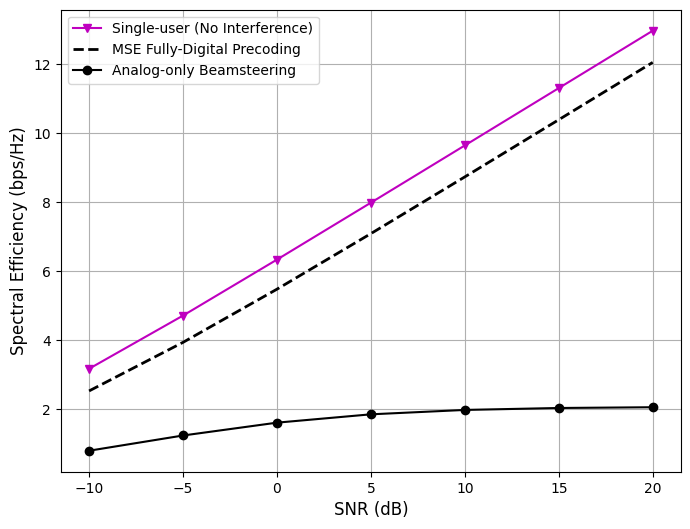

In [7]:
# Plotando a eficiência espectral
plt.figure(figsize=(8, 6))
# plt.plot(SNR_dB_range, Rate_HP_FD_ZF, '-gv', linewidth=1.5, label="ZF fully digital precoding")
plt.plot(SNR_dB_range, Rate_SU, '-mv', linewidth=1.5, label="Single-user (No Interference)")
plt.plot(SNR_dB_range, Rate_HP_FD_MSE, '--k', linewidth=2, label="MSE Fully-Digital Precoding")
# Verificando a condição para o número de caminhos
if Num_paths == 1:
    plt.plot(SNR_dB_range, Rate_BS, '-ro', linewidth=1.5, label="Analog-only Beamsteering")
else:
    plt.plot(SNR_dB_range, Rate_BS, '-ko', linewidth=1.5, label="Analog-only Beamsteering")
# Configurações do gráfico
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Spectral Efficiency (bps/Hz)', fontsize=12)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Laço Principal da Simulação

# A cada iteração, ele gera um novo canal, aplica precoding híbrido e calcula as taxas de transmissão.
for iter in range(ITER):

    # Inicialização das Matrizes
    # Matriz do canal MIMO massivo, com Num_users usuários
    H = np.zeros((Num_users, RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)
    # Vetor de resposta ao array (steering vector) no transmissor.
    a_TX = np.zeros((TX_ant_w * TX_ant_h, Num_users), dtype=complex)
    # Vetor de resposta ao array no receptor
    a_RX = np.zeros((RX_ant_w * RX_ant_h, Num_users), dtype=complex)

    # Arrays que representam as posições das antenas nas UPAs do transmissor e receptor.
    ind_TX_w = np.repeat(np.arange(TX_ant_w), TX_ant_h)
    ind_TX_h = np.tile(np.arange(TX_ant_h), TX_ant_w)
    ind_RX_w = np.repeat(np.arange(RX_ant_w), RX_ant_h)
    ind_RX_h = np.tile(np.arange(RX_ant_h), RX_ant_w)

    # Parâmetros dos Caminhos do Canal
    # Ângulos de partida em elevação (AoD_el)
    AoD_el = np.zeros((Num_users, Num_paths), dtype=complex)
    # Ângulos de partida em azimute (AoD_az)
    AoD_az = np.zeros((Num_users, Num_paths), dtype=complex)
    # Ângulos de chegada em elevação (AoA_el)
    AoA_el = np.zeros((Num_users, Num_paths), dtype=complex)
    # Ângulos de chegada em azimute (AoA_az)
    AoA_az = np.zeros((Num_users, Num_paths), dtype=complex)
    # Ganho complexo de cada caminho
    alpha = np.zeros((Num_users, Num_paths), dtype=complex)

    # Construção do Canal
    for u in range(Num_users):
        AoD_el[u, :] = np.pi * np.random.rand(1, Num_paths) - np.pi / 2
        AoD_az[u, :] = 2 * np.pi * np.random.rand(1, Num_paths)
        AoA_el[u, :] = np.pi * np.random.rand(1, Num_paths) - np.pi / 2
        AoA_az[u, :] = 2 * np.pi * np.random.rand(1, Num_paths)
        # Gera os ângulos de chegada e partida aleatoriamente
        parte_real = norm.ppf(np.random.rand(1, Num_paths))
        parte_imag = 1j * (norm.ppf(np.random.rand(1, Num_paths)))
        # Gera os coeficientes complexos do canal, com parte real e imaginária distribuídas normalmente.
        alpha[u, :] = np.sqrt(1 / Num_paths) * (parte_real + parte_imag)

        # Representa a matriz do canal para um usuário específico.
        # Ela tem dimensão (RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), 
        # o que corresponde ao número total de antenas no receptor e transmissor.
        # Inicialização com zeros complexos porque o canal tem componentes 
        # em fase e quadratura (I/Q).
        Temp_Channel = np.zeros((RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)

        # Loop sobre os Caminhos do Canal
        # Como o canal é multi-caminho (Num_paths caminhos), 
        # iteramos sobre cada um deles para construir Temp_Channel.
        for l in range(Num_paths):
            # Construção do Vetor de Resposta da UPA no Transmissor
            # a_TX[:, u] é o vetor de resposta ao array (steering vector) no transmissor.
            # AoD_az[u, l] e AoD_el[u, l] são os ângulos de partida (azimute e elevação)
            # do sinal para este usuário e caminho.
            
            # Normalização do vetor de resposta ao array (steering vector) no transmissor.
            norm_vec_tx = np.sqrt(1 / (TX_ant_w * TX_ant_h))
            # Considera ângulos de azimute e elevação no transmissor.
            az_el_angle_tx = ind_TX_w * np.sin(AoD_az[u, l]) * np.sin(AoD_el[u, l])
            # Considera a componente vertical no transmissor.
            vertical_part_tx = ind_TX_h * np.cos(AoD_el[u, l])
            # Fase do vetor de resposta no transmissor.
            phase_response_tx = np.exp(1j * np.pi * (az_el_angle_tx + vertical_part_tx))
            # Vetor de Resposta da Antena (UPA)
            # Ligeiramente diferente da Equação 7 do paper
            a_TX[:, u] = (norm_vec_tx * phase_response_tx).flatten(order='F')  
            # O método flatten() transforma uma matriz em um vetor unidimensional.
            # O argumento order='F' significa que a conversão segue a ordem de Fortran (coluna por coluna),
            #  ao invés da ordem C padrão (linha por linha).
            # No MATLAB, os arrays são armazenados por coluna (Fortran-order).
            # No Python (NumPy), os arrays são armazenados por linha (C-order, row-major).
            # Usar flatten(order='F') garante que o código em Python mantenha a mesma estrutura que no MATLAB.
            
            # Construção do Vetor de Resposta da UPA no Receptor
            # a_RX[:, u] é o vetor de resposta ao array (steering vector) no receptor.
            # AoA_az[u, l] e AoA_el[u, l] são os ângulos de chegada (azimute e elevação) 
            # do sinal para este usuário e caminho.
            # Normalização do vetor de resposta ao array (steering vector) no receptor.
            norm_vec_rx = np.sqrt(1 / (RX_ant_w * RX_ant_h))
            # Considera ângulos de azimute e elevação no receptor.
            az_el_angle_rx = ind_RX_w * np.sin(AoA_az[u, l]) * np.sin(AoA_el[u, l])
            # Considera a componente vertical no receptor.
            vertical_part_rx = ind_RX_h * np.cos(AoA_el[u, l])
            # A exponencial complexa (parte8) define a fase dos sinais das antenas do receptor.
            # Fase do vetor de resposta no receptor.
            phase_response_rx = np.exp(1j * np.pi * (az_el_angle_rx + vertical_part_rx))
            a_RX[:, u] = (norm_vec_rx * phase_response_rx).flatten(order='F')  # 'F' mantém a ordem do MATLAB
            # O método flatten() transforma uma matriz em um vetor unidimensional.
            # O argumento order='F' significa que a conversão segue a ordem de Fortran (coluna por coluna),
            #  ao invés da ordem C padrão (linha por linha).
            # No MATLAB, os arrays são armazenados por coluna (Fortran-order).
            # No Python (NumPy), os arrays são armazenados por linha (C-order, row-major).
            # Usar flatten(order='F') garante que o código em Python mantenha a mesma estrutura que no MATLAB.
            
            # Cálculo do Canal para um Caminho Específico
            # alpha[u, l] é o coeficiente de ganho complexo do caminho l do usuário u.
            norm_ant = np.sqrt(TX_ant_w * TX_ant_h) * (RX_ant_w * RX_ant_h)
            Temp_Channel += (norm_ant) * np.outer(alpha[u, l] * a_RX[:, u], a_TX[:, u].conj())
        
        # Atualização da Matriz do Canal do Usuário
        # Após somar as contribuições de todos os caminhos, a Temp_Channel final
        #  representa a matriz do canal completa do usuário u.
        H[u, :, :] = Temp_Channel
    ####################################################################################################################
    # Stage 1 of the proposed algorithm (Analog precoding)
    Frf = np.zeros((TX_ant, Num_users), dtype=complex)
    Wrf = np.zeros((RX_ant, Num_users), dtype=complex)
    for u in range(Num_users):
        Frf[:, u] = a_TX[:, u]
        Wrf[:, u] = a_RX[:, u]
    ####################################################################################################################
    # Constructin the effective channels
    He = np.zeros((Num_users, RX_ant), dtype=complex)
    for u in range(Num_users):
        Channel = np.zeros((RX_ant, TX_ant), dtype=complex)
        Channel[:, :] = H[u, :, :]  # Extraindo a matriz H do usuário u
        He[u, :] = Wrf[:, u].conj().T @ Channel @ Frf  # Cálculo do canal efetivo
    ####################################################################################################################
    # effective channel for fully digital precoding
    He_fd = np.zeros((Num_users, TX_ant), dtype=complex)
    for u in range(Num_users):
        Channel = np.zeros((RX_ant, TX_ant), dtype=complex)
        Channel[:, :] = H[u, :, :]  # Extraindo a matriz H do usuário u
        He_fd[u, :] = Wrf[:, u].conj().T @ Channel  # Cálculo do canal efetivo
    ####################################################################################################################
    # Baseband Zero-Forcing Precoding (ZFBF)
    Fbb = He.conj().T @ (np.linalg.inv(He @ He.conj().T))
    # Normalização dos precodificadores híbridos
    for u in range(Num_users):
        norm_factor = np.sqrt((Frf @ Fbb[:, u]).conj().T @ (Frf @ Fbb[:, u]))
        if norm_factor != 0:  # Evitar divisão por zero
            Fbb[:, u] /= norm_factor  # Normalização
    ####################################################################################################################
    # =====================================================
    # Fully-Digital Zero-Forcing Precoding (ZFBF)
    # =====================================================
    # Ffd = He_fd' * pinv(He_fd * He_fd')
    Ffd = He_fd.conj().T @ np.linalg.pinv(He_fd @ He_fd.conj().T)
    # Normalização dos precodificadores
    for u in range(Num_users):
        norm_factor = np.linalg.norm(Ffd[:, u])  # Correta normalização da coluna
        if norm_factor != 0:  # Evitar divisão por zero
            Ffd[:, u] /= norm_factor
    ####################################################################################################################
    count_i = 0
    for count, SNR_dB_i in enumerate(SNR_dB_range, start=1):
        count_i = count_i + 1
        SNR = 10 ** (0.1 * SNR_dB_i) / Num_users  # Converter dB para valor linear
        sigma2 = 1 / SNR  # Variância do ruído
        ################################################################################################################
        # =====================================================
        # MMSE Baseband Precoder
        # =====================================================
        FbbMSE = np.linalg.inv(He.conj().T @ He + Num_users * sigma2 * Frf.conj().T @ Frf) @ He.conj().T
        # Normalização dos precodificadores híbridos
        for u in range(Num_users):
            norm_factor = np.linalg.norm(Frf @ FbbMSE[:, u])
            if norm_factor != 0:  # Evitar divisão por zero
                FbbMSE[:, u] /= norm_factor
        ################################################################################################################
        # =====================================================
        # Fully-Digital MMSE Precoding
        # =====================================================
        # FfdMSE = inv(He_fd'*He_fd + Num_users*sigma2*eye(TX_ant)) * He_fd'
        FfdMSE = np.linalg.inv(He_fd.conj().T @ He_fd + Num_users * sigma2 * np.eye(TX_ant)) @ He_fd.conj().T
        # Normalização dos precodificadores
        for u in range(Num_users):
            norm_factor = np.linalg.norm(FfdMSE[:, u])  # Correta normalização da coluna
            if norm_factor != 0:  # Evitar divisão por zero
                FfdMSE[:, u] /= norm_factor
        ################################################################################################################
                ################################################################################################################
        # MSE fully digital precoding
        Rate_HP_FD_MSE[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
                                                             SNR * (He_fd @ (FfdMSE @ FfdMSE.conj().T) @ He_fd.conj().T))) / (Num_users * ITER)

    ###########################################################################
    

In [ ]:
# Plotando a eficiência espectral
plt.figure(figsize=(8, 6))
plt.plot(SNR_dB_range, Rate_SU, '-mv', linewidth=1.5, label="Single-user (No Interference)")
plt.plot(SNR_dB_range, Rate_HP, '-rs', linewidth=1.5, label="ZF Hybrid Precoding")
plt.plot(SNR_dB_range, Rate_HP_MSE, '-b*', linewidth=1.5, label="MMSE Hybrid Precoding")
plt.plot(SNR_dB_range, Rate_HP_Kalman, '-go', linewidth=1.5, label="Kalman Hybrid Precoding")
plt.plot(SNR_dB_range, Rate_HP_FD_MSE, '--k', linewidth=2, label="MSE Fully-Digital Precoding")

# Verificando a condição para o número de caminhos
if Num_paths == 1:
    plt.plot(SNR_dB_range, Rate_BS, '-ro', linewidth=1.5, label="Analog-only Beamsteering")
else:
    plt.plot(SNR_dB_range, Rate_BS, '-ko', linewidth=1.5, label="Analog-only Beamsteering")

# Configurações do gráfico
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Spectral Efficiency (bps/Hz)', fontsize=12)
plt.legend()
plt.grid()
plt.show()
